In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [123]:
# Import data
df = pd.read_csv('../data/AviationData.csv', encoding='latin-1')
state_codes = pd.read_csv('../data/USState_Codes.csv')

/Users/meghanapakala/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Initial Data Cleaning

In [124]:
# Change the date column to a datetime object
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
# Creating a column for the year and insert next to Event.Date
df['Year'] = df['Event.Date'].dt.year
df.insert(4, 'Year', df.pop('Year'))

# Making everything in the df lowercase so we can get more accurate counts
df = df.applymap(lambda x: x.lower() if type(x) == str else x)
# Renaming columns in titlecase (aesthetic purposes only)
df = df.rename(columns={'Event.Id':'Event.ID','Aircraft.damage':'Aircraft.Damage','Purpose.of.flight':'Purpose.of.Flight','Air.carrier':'Air.Carrier','Broad.phase.of.flight':'Broad.Phase.of.Flight'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.ID                88889 non-null  object        
 1   Investigation.Type      88889 non-null  object        
 2   Accident.Number         88889 non-null  object        
 3   Event.Date              88889 non-null  datetime64[ns]
 4   Year                    88889 non-null  int64         
 5   Location                88837 non-null  object        
 6   Country                 88663 non-null  object        
 7   Latitude                34382 non-null  object        
 8   Longitude               34373 non-null  object        
 9   Airport.Code            50249 non-null  object        
 10  Airport.Name            52790 non-null  object        
 11  Injury.Severity         87889 non-null  object        
 12  Aircraft.Damage         85695 non-null  object

### Geographic Filtering

In [125]:
# Filtering out non-US incidents and removing column
df = df[df['Country'] == 'united states']
df = df.drop(columns=['Country'])

# Pull state info from locations and create new column next to Location
df['State'] = df['Location'].str.split(',').str[-1].str.strip().str.upper()
df.insert(6, 'State', df.pop('State'))
df['State'].value_counts()

CA    8857
TX    5913
FL    5825
AK    5672
AZ    2834
      ... 
PO      14
GU       8
VI       6
UN       3
CB       1
Name: State, Length: 61, dtype: int64

In [126]:
# Merge state names to abbreviated codes
df = pd.merge(df, state_codes, how='left', left_on='State', right_on='Abbreviation')
df = df.drop(['Abbreviation'], 1)
df = df.rename(columns={'State':'State.Code','US_State':"State.Name"})
df.insert(7, 'State.Name', df.pop('State.Name'))

In [127]:
# Mapping states to regions based off data from http://nationalgeographic.org/maps/united-states-regions/
# DC is categorized as a state; Atlantic and Pacific categorized as 'Ocean'
# Guam, PR, VI, Gulf of Mexico categorized as 'Other Territory'


states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'Maryland': 'South', 'Virginia': 'South', 'Kentucky': 'South', 
    'Tennessee': 'South', 'North Carolina': 'South', 'Mississippi': 'South', 'Arkansas': 'South', 
    'Louisiana': 'South', 'Alabama': 'South', 'Georgia': 'South', 'South Carolina': 'South', 
    'Florida': 'South', 'Delaware': 'South', 'Arizona': 'Southwest', 'New Mexico': 'Southwest', 
    'Oklahoma': 'Southwest', 'Texas': 'Southwest', 'Washington_DC': 'South', 
    'Guam': 'Other Territory', 'Puerto Rico': 'Other Territory', 'Virgin Islands': 'Other Territory',
     'Gulf of mexico': 'Other Territory', 'Atlantic ocean': 'Ocean', 'Pacific ocean': 'Ocean' }

df['Region'] = df['State.Name'].map(states_to_regions)
df.insert(8, 'Region', df.pop('Region'))
df['Region'].value_counts()

West               27936
South              19582
Midwest            15469
Southwest          11345
Northeast           7618
Other Territory      172
Ocean                 31
Name: Region, dtype: int64

### Aircraft Type

In [128]:
# Filtering out 'Amateur.Built' aircraft and removing column
df = df[df['Amateur.Built'] == 'no']
df = df.drop(columns=['Amateur.Built'])

<AxesSubplot:>

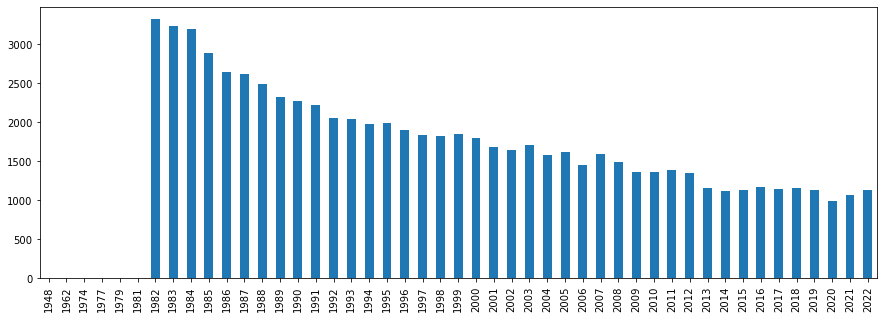

In [129]:
# One interesting thing to note here is the difference in the number of entries per year
# Here it is *before* we filter out non-airplane incidents

df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

<AxesSubplot:>

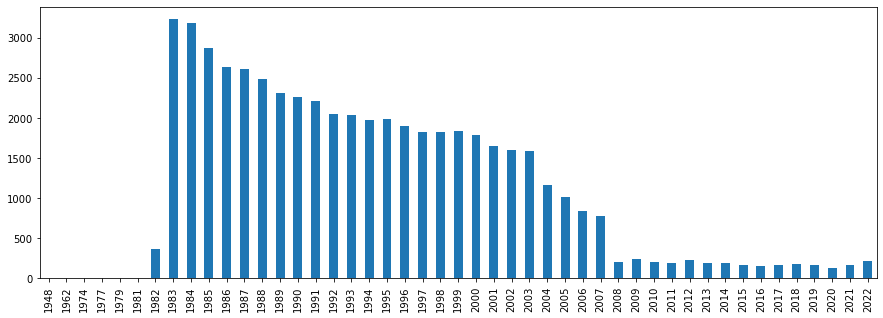

In [130]:
# We can see that the airplane-related incidents and the non-airplane-related incidents are mirror images of each other

df_notplanes = df[df['Aircraft.Category'] != 'airplane']
df_notplanes['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

<AxesSubplot:>

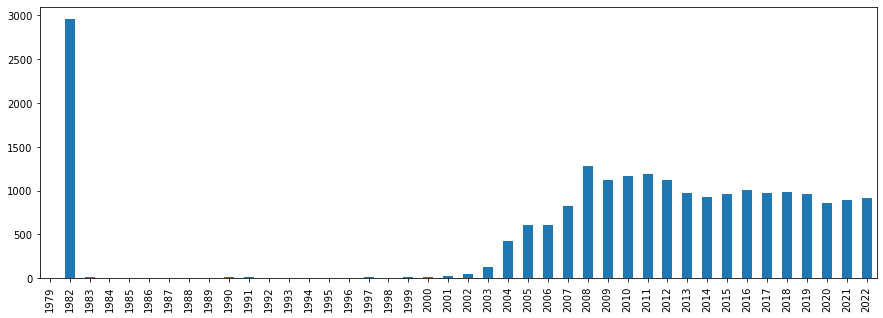

In [131]:
# Filtering out all non-'airplane' incidents and removing column
df = df[df['Aircraft.Category'] == 'airplane']
df = df.drop(columns=['Aircraft.Category'])

# And now regraph after the filtering:
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

### FAR Codes & Purpose of Flight

In [132]:
# Cleaning up the FAR.Description column using a .replace() 
# See here for more info on FAR: 
# https://pilotinstitute.com/part-91-vs-121-vs-135/

df['FAR.Description'] = df['FAR.Description'].replace({
    '091': 'part 91',
    'part 91: general aviation': 'part 91',
    '137': 'part 137',
    '135': 'part 135',
    '121': 'part 121',
    'part 137: agricultural': 'part 137',
    'part 135: air taxi & commuter': 'part 135',
    '129': 'part 129',
    'part 121: air carrier': 'part 121',
    '133': 'part 133',
    'part 129: foreign': 'part 129',
    'part 133: rotorcraft external load': 'part 133',
    'part 133: rotorcraft ext. load': 'part 133',
    '125' : 'part 125',
    'part 125: 20+ pax,6000+ lbs': 'part 125',
    '107': 'part 107',
    '103': 'part 103',
    '437': 'part 437',
    'part91f': 'part 91',
    'part 91 subpart f': 'part 91',
    'part 91f: special flt ops.': 'part 91',
    'part 91 subpart k: fractional': 'part 91',
    '091k': 'part 91',
    'pubu': 'public',
    'public use': 'public',
    'public aircraft': 'public',
    'armed forces': 'armf',
}
)

df['FAR.Description'].value_counts()

part 91     18388
part 137     1099
part 135      756
part 121      632
public        134
part 129       59
nusc           12
unknown        10
nusn           10
part 125        8
unk             7
part 133        2
armf            2
Name: FAR.Description, dtype: int64

In [133]:
df['Purpose.of.Flight'].value_counts()

personal                     13042
instructional                 3059
aerial application            1014
business                       723
unknown                        551
positioning                    337
skydiving                      158
aerial observation             154
ferry                          148
other work use                 142
executive/corporate            138
flight test                    114
banner tow                      89
public aircraft - federal       48
air race show                   39
public aircraft                 38
glider tow                      34
public aircraft - state         24
firefighting                    14
public aircraft - local         12
asho                             5
air race/show                    4
pubs                             3
air drop                         3
Name: Purpose.of.Flight, dtype: int64

In [134]:
# New column 'Purpose.Binned' to group 'Purpose.of.Flight' into more general categories
# New category 'public' to include 'public aircraft', 'public aircraft - federal', 'public aircraft - state', 'public aircraft - local', 'public aircraft - u.s. govt.'
df['Purpose.Binned'] = df['Purpose.of.Flight'].replace(['public aircraft', 'public aircraft - federal', 'public aircraft - state', 'public aircraft - local', 'public aircraft - u.s. govt.'], 'public')

# New category 'business' to include 'aerial application', 'business', 'other work use', 'banner tow', 'air drop'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['aerial application', 'business', 'other work use', 'banner tow', 'air drop'], 'business')

# New category 'recreational' to include 'skydiving', 'glider tow'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['skydiving', 'glider tow'], 'recreational')

# New category 'small transport' to include 'executive/corporate', 'ferry'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['executive/corporate', 'ferry'], 'small transport')

# Adding 'pubs', 'firefighting' to category 'public'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['pubs', 'firefighting'], 'public')

# Adding 'flight test' to category 'instructional'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['flight test'], 'instructional')

# New category 'air show' to include 'air race show', 'air race/show', 'asho'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['air race show', 'air race/show', 'asho'], 'air show')

df.insert(23, 'Purpose.Binned', df.pop('Purpose.Binned'))
df['Purpose.Binned'].value_counts()

personal              13042
instructional          3173
business               1971
unknown                 551
positioning             337
small transport         286
recreational            192
aerial observation      154
public                  139
air show                 48
Name: Purpose.Binned, dtype: int64

### Filtering the 'Make' series


In [135]:
# Checking out the raw 'Make' values
df['Make'].value_counts()

cessna                7697
piper                 4322
beech                 1522
boeing                 456
mooney                 391
                      ... 
kevin p stolhammer       1
honda aircraft           1
meyer fred j             1
bristol                  1
kenneth m franz          1
Name: Make, Length: 1015, dtype: int64

In [136]:
# Make a list of all the entries that have "cessna" in them and return their strings in a list
cessna_list = df[df['Make'].str.contains('cessna')]['Make'].unique().tolist()

#Do the same with the other big makes
grumman_list = df[df['Make'].str.contains('grumman')]['Make'].unique().tolist()
dehavilland_list = df[df['Make'].str.contains('havilland')]['Make'].unique().tolist()
cirrus_list = df[df['Make'].str.contains('cirrus')]['Make'].unique().tolist()
piper_list = df[df['Make'].str.contains('piper')]['Make'].unique().tolist()
boeing_list = df[df['Make'].str.contains('boeing')]['Make'].unique().tolist()
mooney_list = df[df['Make'].str.contains('mooney')]['Make'].unique().tolist()
airtractor_list = df[df['Make'].str.contains('air tractor')]['Make'].unique().tolist()

print(cessna_list)
print(grumman_list)
print(dehavilland_list)
print(cirrus_list)
print(piper_list)
print(boeing_list)
print(mooney_list)
print(airtractor_list)

['cessna', 'cessna aircraft co', 'cessna/air repair inc', 'cessna/weaver', 'cessna ector', 'cessna aircraft', 'cessna aircraft co.']
['grumman', 'grumman american', 'grumman-schweizer', 'grumman american avn. corp.', 'grumman american aviation', 'grumman acft eng', 'grumman acft eng cor-schweizer', 'grumman aircraft eng corp', 'grumman american aviation corp', 'grumman aircraft', 'grumman schweizer', 'grumman acft eng cor', 'grumman aircraft cor-schweizer', 'grumman american avn. corp']
['de havilland', 'dehavilland', 'dehavilland canada']
['cirrus design corp.', 'cirrus', 'cirrus design', 'cirrus design corp', 'cirrus design corporation']
['piper', 'piper-aerostar', 'piper aircraft', 'piper/cub crafters', 'piper cub crafters', 'piper aerostar', 'new piper aircraft inc', 'piper aircraft inc', 'jetprop dlx piper', "piper/wally's flyers inc", 'piper aircraft, inc.', 'new piper', 'piper / laudeman', 'piper-harris', 'piper aircraft corporation']
['boeing', 'boeing stearman', 'boeing of can

In [137]:
df['Make'] = df['Make'].replace(cessna_list, 'cessna')
df['Make'] = df['Make'].replace(grumman_list, 'grumman')
df['Make'] = df['Make'].replace(dehavilland_list, 'dehavilland')
df['Make'] = df['Make'].replace(cirrus_list, 'cirrus')
df['Make'] = df['Make'].replace(piper_list, 'piper')
df['Make'] = df['Make'].replace(mooney_list, 'mooney')
df['Make'] = df['Make'].replace(airtractor_list, 'airtractor')

# And we can now see the totals, with slightly different numbers than before.
df['Make'].value_counts()

cessna                  7730
piper                   4368
beech                   1522
boeing                   456
mooney                   437
                        ... 
blue side up inc           1
dusenberry mark j          1
new kolb aircraft co       1
aaa aircraft llc           1
kitty hawk                 1
Name: Make, Length: 968, dtype: int64

In [138]:
# Making a new df that only accepts the top 25 makes:
top_makes = df['Make'].value_counts().head(25).index.tolist()
top_makes_df = df[df['Make'].isin(top_makes)].copy()
top_makes_df['Make'].value_counts()

cessna                       7730
piper                        4368
beech                        1522
boeing                        456
mooney                        437
airtractor                    414
grumman                       409
cirrus                        330
bellanca                      279
aeronca                       226
maule                         225
dehavilland                   165
champion                      164
luscombe                      162
stinson                       145
north american                114
taylorcraft                   109
aero commander                 95
embraer                        85
airbus                         80
aviat aircraft inc             76
diamond aircraft ind inc       73
aviat                          68
ercoupe                        66
raytheon aircraft company      61
Name: Make, dtype: int64

### Airports

In [139]:
# Clean airport names

df['Airport.Name'] = df['Airport.Name'].replace(['private airstrip', 'private strip', 'pvt'], 'private')
df['Airport.Name'].value_counts()

private                           345
none                               38
merrill field                      34
phoenix deer valley                25
north las vegas                    23
                                 ... 
fairbanks                           1
delaware muni - jim moore fiel      1
rochester intl airport              1
j a knolle                          1
berry hill airport                  1
Name: Airport.Name, Length: 8558, dtype: int64

### Weather

In [140]:
# Clean 'Weather.Condition'

df['Weather.Condition'] = df['Weather.Condition'].str.upper()
df['Weather.Condition'].value_counts()

# VMC - Visual Meteorological Conditions - generally clear and good visibility; pilots can navigate and operate aircraft by visual reference to the ground
# IMC - Instrument Meteorological Conditions - reduced visibility due to factors like fog, rain, or low clouds; pilots may need to rely on instruments for navigation and control
# UNK - Unknown

VMC    19278
IMC     1253
UNK      162
Name: Weather.Condition, dtype: int64

### Injury Severity

In [141]:
# Looking at the 'Injury.Severity' column
# We see that it tells us how many people died in a given incident
df['Injury.Severity'].value_counts().head(20)

non-fatal    17469
fatal         2442
fatal(1)       308
fatal(2)       221
incident       164
minor          138
serious         95
fatal(3)        75
fatal(4)        60
fatal(5)        22
fatal(6)        14
fatal(7)         9
fatal(8)         7
fatal(10)        4
fatal(12)        3
fatal(65)        1
fatal(16)        1
fatal(9)         1
fatal(11)        1
fatal(14)        1
Name: Injury.Severity, dtype: int64

In [142]:
# Split number from Fatal(#) to count number of fatalities
# Create a new column tracking the number of these fatalities
df['Num.Fatalities'] = df['Injury.Severity'].str.split('(').str[-1]
df['Num.Fatalities'] = df['Num.Fatalities'].str.split(')').str[0]
df['Num.Fatalities'] = pd.to_numeric(df['Num.Fatalities'], errors='coerce').fillna(0).astype(int)
df.insert(14, 'Num.Fatalities', df.pop('Num.Fatalities'))
df['Num.Fatalities'].value_counts()

0      20389
1        308
2        221
3         75
4         60
5         22
6         14
7          9
8          7
10         4
12         3
9          1
13         1
228        1
11         1
27         1
65         1
17         1
16         1
14         1
Name: Num.Fatalities, dtype: int64

In [143]:
# Update labeling in 'Injury.Severity' column, since we now have a different column that tracks total number of fatalities

df['Injury.Severity'] = df['Injury.Severity'].str.split('(').str[0]
df['Injury.Severity'].value_counts()

non-fatal    17469
fatal         3174
incident       164
minor          138
serious         95
Name: Injury.Severity, dtype: int64

In [144]:
# Move other injury columns next to Injury.Severity
df.insert(15, 'Total.Fatal.Injuries', df.pop('Total.Fatal.Injuries'))
df.insert(16, 'Total.Serious.Injuries', df.pop('Total.Serious.Injuries'))
df.insert(17, 'Total.Minor.Injuries', df.pop('Total.Minor.Injuries'))
df.insert(18, 'Total.Uninjured', df.pop('Total.Uninjured'))

### Damage Severity Score

Making a 'DS.Score' column that takes the 'Aircraft.damage' column and reassigns each category a number:

    - 'destroyed' -> 2
    - 'substantial' -> 1
    - 'minor' -> 0
    
For the time being, 'unknown' is left as such.

In [145]:
# Make a DS.Score based on the 'Aircraft.Damage' column

df['DS.Score'] = df['Aircraft.Damage'].replace({
    'destroyed': 2,
    'substantial': 1,
    'minor': 0,
})
df['DS.Score'].value_counts()

df.insert(20, 'DS.Score', df.pop('DS.Score'))

# Save cleaned .csv

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21121 entries, 5 to 82245
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.ID                21121 non-null  object        
 1   Investigation.Type      21121 non-null  object        
 2   Accident.Number         21121 non-null  object        
 3   Event.Date              21121 non-null  datetime64[ns]
 4   Year                    21121 non-null  int64         
 5   Location                21121 non-null  object        
 6   State.Code              21121 non-null  object        
 7   State.Name              21065 non-null  object        
 8   Region                  21065 non-null  object        
 9   Latitude                17946 non-null  object        
 10  Longitude               17939 non-null  object        
 11  Airport.Code            14817 non-null  object        
 12  Airport.Name            15226 non-null  object

In [147]:
# Save cleaned df to a new csv file
# df.to_csv('../data/AviationData_cleaned.csv', index=False)